Otpimization methods (Differential Evolution, Particule Swarm Optimization, Bayesian Optimization and Maximum A Poteriori) on ODE data. 

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

import warnings
warnings.simplefilter("ignore")

%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [3]:
! mkdir -p $cwd/results

In [4]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="lime", alpha=0.9, zorder=4)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="cyan", alpha=0.9, zorder=4)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))
    
from numba import njit
@njit
def set_seed(value):
    np.random.seed(value)

# Simulator

In [5]:
#Simulator

def Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts):
   
    delta, eta, J  = params[0], params[1], params[2]

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init = constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt)  * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.array(v).reshape(-1), np.array(r).reshape(-1)

In [6]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

### Simulation parameters

In [7]:
delta=0.7
eta=-4.6
J=14.5

v0 = -3.
r0 = 0.5

t_init = 0.0
t_final = 100.0
dt = 0.001
ts = np.arange(t_init,t_final,dt)

I0=3.
t_on=30.
t_off=60.

#uniform I
I_input = [0 for i in range(int((t_on - t_init)/dt))] +\
[I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.array(I_input)

prms = [delta, eta, J]
inits = [v0, r0]

sigma=0.0
sigma_noise = sigma

In [8]:
params_true = prms
print(params_true)

[0.7, -4.6, 14.5]


# Load data

In [9]:
sigma = 0.0
data_input_filename=str('data_input_mpr_sd'+ '_sigma='+str(sigma))
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(load(data_input_path))
v_obs, r_obs = data_input['vs'], data_input['rs']
X_obs = np.vstack((v_obs, r_obs))

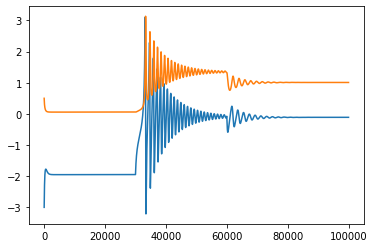

In [10]:
plt.plot(v_obs)
plt.plot(r_obs)

# Inference

In [11]:
bounds=[(0.2, 5), (-10, -3), (5,  20)]

In [12]:
#trick variables to retrieve the fits
global cost_model_list
global X_model_list 

## DE

In [13]:
from scipy.optimize import differential_evolution

In [14]:
def black_box_function(x):
    prms_proposal = [0] * 3
    prms_proposal[0] = x[0]
    prms_proposal[1] = x[1]
    prms_proposal[2] = x[2]
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, sigma_noise, dt, ts)
    
    X_model = np.vstack((sim[0], sim[1]))
    cost_model = np.sqrt(np.sum((X_model - X_obs)**2))
    
    if cost_model < min(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)
        
    return cost_model

In [15]:
def callback(xk, convergence):
    val.append(convergence)
    cost_val.append(black_box_function(xk))

In [16]:
%%time

cost_model_list  = [100000]
X_model_list = [100000]

val=[]
cost_val=[]
max_iter = 500

set_seed(0)
result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=max_iter, seed=0,
                                callback=callback)

CPU times: user 51 s, sys: 78.1 ms, total: 51 s
Wall time: 51.1 s


In [17]:
result.x, result.fun

(array([ 0.7, -4.6, 14.5]), 6.469601199052206e-14)

In [18]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)] - X_obs)**2))

6.469601199052206e-14

In [19]:
cost_final = result.fun
params_est = result.x

In [20]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

0.0

In [21]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)].copy()

New simulation with optimal parameters:

In [22]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [23]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

In [24]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/DE_simODE_output.json", "w") as outfile:
    outfile.write(json_object)

## PSO

In [25]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [26]:
n_particles=10

In [27]:
def black_box_function_pso(x):
    prms_proposal = np.zeros((n_particles, 3))

    prms_proposal[:, 0] = x[:, 0]
    prms_proposal[:, 1] = x[:, 1]
    prms_proposal[:, 2] = x[:, 2]
    
    params_val = prms_proposal
    #sim = np.zeros((n_particles, X_obs.shape[0], X_obs.shape[1]))
    costf = np.zeros(n_particles)
    for i in range(n_particles):
        sim_i = Montbrio_SDEmodel_numba(list(params_val[i, :]), inits, I_input, sigma_noise, dt, ts)
        X_model_i = sim_i[0], sim_i[1]
        costf[i] = np.sqrt(np.sum((X_model_i - X_obs)**2))
        
        if costf[i] < min(cost_model_list) :
            cost_model_list.append(costf[i])
            X_model_list.append(X_model_i)
            
    return costf

In [28]:
lb = np.array(bounds)[:, 0]
ub = np.array(bounds)[:, 1]
(lb, ub)

(array([  0.2, -10. ,   5. ]), array([ 5., -3., 20.]))

In [29]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

#### Fixed dynamical noise 0.1 :

In [30]:
%%time

cost_model_list  = [100000]
X_model_list = [100000]

set_seed(0)
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=3, options=options, bounds=(lb, ub))
cost, pos = optimizer.optimize(black_box_function_pso, iters=500)

2023-05-22 11:29:49,039 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|500/500, best_cost=118
2023-05-22 11:30:24,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 118.12723806994613, best pos: [ 1.58866696 -6.57689241 16.2921068 ]


CPU times: user 35 s, sys: 329 ms, total: 35.4 s
Wall time: 35.1 s


In [31]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)] - X_obs)**2))

118.12723806994613

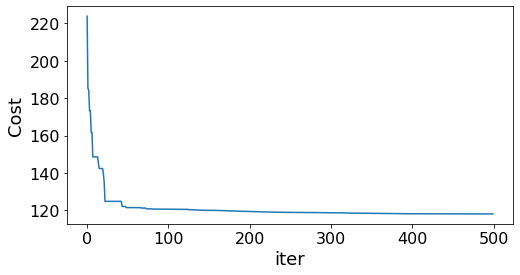

In [32]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [33]:
cost_final = cost
params_est = pos

In [34]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

1.6237281546649147

In [35]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)]

New simulation with optimal parameters:

In [36]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [37]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

In [38]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/PSO2_simODE_output.json", "w") as outfile:
    outfile.write(json_object)

## Bayesian Optimization

In [39]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization #v1.4.0
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [40]:
def black_box_function_BO(delta, eta, J):
    prms_proposal = [0] * 3
    prms_proposal[0] = delta
    prms_proposal[1] = eta
    prms_proposal[2] = J
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, sigma_noise, dt, ts)

    X_model = np.vstack([sim[0], sim[1]])
    cost_model = np.nan_to_num(-1*np.sqrt(np.sum((X_model - X_obs)**2)), nan=-1000)
    
    if cost_model > max(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)
        
    return cost_model

In [41]:
pbounds = {'delta': bounds[0], 'eta': bounds[1], 'J': bounds[2]}
pbounds

{'delta': (0.2, 5), 'eta': (-10, -3), 'J': (5, 20)}

#### Fixed noise = 0.1

In [42]:
%%time

cost_model_list  = [-100000]
X_model_list = [-100000]

set_seed(0)
optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds, random_state=0)
optimizer.maximize(init_points=50, n_iter=450, kappa=100)

|   iter    |  target   |     J     |   delta   |    eta    |
-------------------------------------------------------------
| 1         | -344.0    | 13.23     | 3.633     | -5.781    |
| 2         | -395.5    | 13.17     | 2.234     | -5.479    |
| 3         | -325.3    | 11.56     | 4.481     | -3.254    |
| 4         | -445.8    | 10.75     | 4.0       | -6.298    |
| 5         | -596.9    | 13.52     | 4.643     | -9.503    |
| 6         | -511.2    | 6.307     | 0.297     | -4.172    |
| 7         | -415.5    | 16.67     | 4.376     | -3.15     |
| 8         | -411.1    | 16.99     | 2.415     | -4.536    |
| 9         | -728.3    | 6.774     | 3.272     | -8.997    |
| 10        | -203.9    | 19.17     | 2.705     | -7.097    |
| 11        | -536.9    | 8.968     | 3.916     | -6.807    |
| 12        | -597.8    | 13.53     | 0.2902    | -5.677    |
| 13        | -364.4    | 14.18     | 3.161     | -3.394    |
| 14        | -479.2    | 15.23     | 1.926     | -6.941    |
| 15    

| 81        | -210.1    | 17.48     | 1.049     | -5.282    |
| 82        | -149.0    | 17.52     | 1.337     | -6.75     |
| 83        | -664.2    | 17.62     | 0.4245    | -7.058    |
| 84        | -161.8    | 17.29     | 1.825     | -6.309    |
| 85        | -179.7    | 18.33     | 1.707     | -6.452    |
| 86        | -154.3    | 17.35     | 2.225     | -7.145    |
| 87        | -161.3    | 17.76     | 1.99      | -6.874    |
| 88        | -479.3    | 19.98     | 0.5862    | -3.013    |
| 89        | -498.8    | 20.0      | 5.0       | -3.0      |
| 90        | -186.6    | 17.51     | 1.895     | -7.601    |
| 91        | -162.3    | 17.06     | 1.858     | -6.821    |
| 92        | -366.0    | 15.1      | 5.0       | -3.987    |
| 93        | -385.3    | 8.777     | 3.375     | -4.424    |
| 94        | -185.3    | 17.69     | 1.447     | -6.1      |
| 95        | -421.9    | 5.0       | 0.2       | -3.0      |
| 96        | -435.0    | 17.16     | 2.909     | -7.764    |
| 97    

| 162       | -207.7    | 16.0      | 1.517     | -4.412    |
| 163       | -172.2    | 17.0      | 2.402     | -6.429    |
| 164       | -202.4    | 17.01     | 1.319     | -7.0      |
| 165       | -215.9    | 18.93     | 1.494     | -6.07     |
| 166       | -151.5    | 16.76     | 1.831     | -6.234    |
| 167       | -445.9    | 17.95     | 5.0       | -3.0      |
| 168       | -382.7    | 15.08     | 4.369     | -3.001    |
| 169       | -195.9    | 19.97     | 3.172     | -9.627    |
| 170       | -187.5    | 19.1      | 3.665     | -8.688    |
| 171       | -206.0    | 19.54     | 2.314     | -7.409    |
| 172       | -198.5    | 18.58     | 2.088     | -6.61     |
| 173       | -516.4    | 20.0      | 2.478     | -3.0      |
| 174       | -350.6    | 11.81     | 1.993     | -4.208    |
| 175       | -241.1    | 17.46     | 1.152     | -4.51     |
| 176       | -326.8    | 11.71     | 4.98      | -4.189    |
| 177       | -310.8    | 14.73     | 4.065     | -6.207    |
| 178   

| 243       | -210.1    | 15.43     | 2.551     | -5.518    |
| 244       | -494.0    | 8.359     | 0.2021    | -3.901    |
| 245       | -354.3    | 9.531     | 2.576     | -3.982    |
| 246       | -385.0    | 5.763     | 1.388     | -3.0      |
| 247       | -204.2    | 12.47     | 1.385     | -3.538    |
| 248       | -330.9    | 13.31     | 5.0       | -5.92     |
| 249       | -212.5    | 17.76     | 1.454     | -5.367    |
| 250       | -461.3    | 16.46     | 1.896     | -7.066    |
| 251       | -166.7    | 15.91     | 2.429     | -6.378    |
| 252       | -168.3    | 16.39     | 2.456     | -6.307    |
| 253       | -433.0    | 6.387     | 5.0       | -4.017    |
| 254       | -350.3    | 8.289     | 5.0       | -3.0      |
| 255       | -216.8    | 19.66     | 1.522     | -6.448    |
| 256       | -579.2    | 16.78     | 0.8388    | -6.345    |
| 257       | -351.9    | 12.42     | 1.436     | -3.0      |
| 258       | -175.7    | 17.58     | 2.51      | -6.793    |
| 259   

| 324       | -343.2    | 16.26     | 5.0       | -6.541    |
| 325       | -198.7    | 19.94     | 3.082     | -8.629    |
| 326       | -223.2    | 16.65     | 1.215     | -4.392    |
| 327       | -202.0    | 14.33     | 0.983     | -3.839    |
| 328       | -432.9    | 15.7      | 1.82      | -6.274    |
| 329       | -568.5    | 13.89     | 2.193     | -7.62     |
| 330       | -135.8    | 16.2      | 1.211     | -5.857    |
| 331       | -149.6    | 16.32     | 1.683     | -6.076    |
| 332       | -177.7    | 15.92     | 2.378     | -5.718    |
| 333       | -160.5    | 15.91     | 1.343     | -5.688    |
| 334       | -427.6    | 17.89     | 3.761     | -4.411    |
| 335       | -704.0    | 14.65     | 0.2142    | -7.44     |
| 336       | -831.5    | 20.0      | 0.2       | -10.0     |
| 337       | -135.2    | 16.12     | 1.411     | -6.178    |
| 338       | -328.1    | 10.95     | 5.0       | -3.57     |
| 339       | -373.0    | 15.19     | 3.739     | -3.872    |
| 340   

| 405       | -187.6    | 17.92     | 2.321     | -6.416    |
| 406       | -579.1    | 6.915     | 3.191     | -6.589    |
| 407       | -217.3    | 19.57     | 1.903     | -6.846    |
| 408       | -412.9    | 17.2      | 5.0       | -3.94     |
| 409       | -339.8    | 15.71     | 4.26      | -6.007    |
| 410       | -202.6    | 16.53     | 1.936     | -5.092    |
| 411       | -148.9    | 14.25     | 0.9028    | -4.372    |
| 412       | -393.1    | 16.43     | 0.2372    | -4.159    |
| 413       | -291.1    | 17.82     | 1.131     | -3.87     |
| 414       | -243.1    | 19.29     | 1.741     | -5.551    |
| 415       | -487.4    | 19.95     | 3.899     | -4.025    |
| 416       | -211.3    | 19.64     | 2.038     | -8.403    |
| 417       | -164.0    | 14.9      | 0.9453    | -4.548    |
| 418       | -178.8    | 16.41     | 1.243     | -5.773    |
| 419       | -153.5    | 16.29     | 0.8539    | -5.25     |
| 420       | -192.9    | 16.05     | 0.9854    | -5.144    |
| 421   

| 486       | -330.2    | 12.42     | 5.0       | -3.8      |
| 487       | -188.5    | 19.53     | 3.293     | -8.852    |
| 488       | -169.6    | 15.18     | 1.702     | -5.091    |
| 489       | -203.0    | 20.0      | 3.012     | -8.131    |
| 490       | -447.3    | 15.8      | 3.796     | -8.156    |
| 491       | -281.1    | 20.0      | 0.9696    | -6.291    |
| 492       | -836.9    | 9.885     | 0.2       | -10.0     |
| 493       | -509.4    | 9.989     | 0.2       | -4.147    |
| 494       | -323.9    | 13.17     | 3.975     | -4.452    |
| 495       | -197.4    | 16.69     | 3.529     | -7.165    |
| 496       | -346.7    | 16.83     | 4.001     | -6.798    |
| 497       | -476.8    | 6.252     | 2.862     | -4.882    |
| 498       | -324.0    | 11.34     | 1.509     | -3.0      |
| 499       | -366.9    | 16.07     | 4.166     | -5.148    |
| 500       | -454.7    | 10.11     | 5.0       | -6.284    |
CPU times: user 12min 59s, sys: 10min 17s, total: 23min 17s
Wall time:

In [43]:
print(optimizer.max)

{'target': -131.33411674670518, 'params': {'J': 16.43257949542188, 'delta': 1.3699976564745766, 'eta': -6.199250014337757}}


In [44]:
np.sqrt(np.sum((X_model_list[np.argmax(cost_model_list)] - X_obs)**2))

131.33411674670518

In [45]:
cost_final = -optimizer.max['target']
params_opt = optimizer.max['params']
params_est = np.array([params_opt[prm] for prm in ['delta', 'eta', 'J']])
params_est

array([ 1.36999766, -6.19925001, 16.4325795 ])

In [46]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

1.499039800913219

In [47]:
v_fit, r_fit = X_model_list[np.argmax(cost_model_list)]

New simulation with optimal parameters:

In [48]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [49]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

In [50]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est), 
            'v_fit': list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/bayesopt_simODE_output.json", "w") as outfile:
    outfile.write(json_object)

## MAP

In [11]:
import cmdstanpy

In [ ]:
stan_models_dir = cwd + '/stan_models/'

In [12]:
model='uniform_fixedsig'
cmdModel = cmdstanpy.CmdStanModel(stan_file= stan_models_dir  + model + '.stan')
cmdModel.compile()

In [13]:
%%time

data = data_input.copy()
data['rs'] = X_obs[1, :]
data['vs'] = X_obs[0, :]
data['ds'] = 1 #no downsampling

fit = cmdModel.optimize(data=data, seed=0)

12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.47 s, sys: 117 ms, total: 1.58 s
Wall time: 2min 29s


In [14]:
fit_vars = fit.stan_variables()

In [15]:
params_est = np.array([fit_vars['delta'], fit_vars['eta'], fit_vars['J']])

In [16]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

3.978480816831973

In [17]:
X_est = np.vstack((fit_vars['v'], fit_vars['r']))
cost_final = np.sqrt(np.sum((X_est - X_obs)**2))
cost_final

0.0012856420968787798

New simulation with optimal parameters:

In [19]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, sigma_noise, dt, ts)

In [20]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

In [21]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est), 
            'v_fit': list(fit_vars['v']), 'r_fit': list(fit_vars['r']), 
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'eps': fit_vars['eps'],
            'sigma': sigma_noise, 
            'rmse_prms': rmse_prms, 'cost': cost_final}
json_object = json.dumps(res_dict, indent=4)
with open("results/map_simODE_output.json", "w") as outfile:
    outfile.write(json_object)